## Experimental sensitivity

In [1]:
import sys
sys.path.append("/home/mariacst/exoplanets/exoplanets/python/")
import imp
import mock_generation
imp.reload(mock_generation)
from mock_generation import mock_population_all
import numpy as np
from lmfit import minimize, Parameters, fit_report 
from scipy.interpolate import griddata
from utils import heat, temperature_withDM, temperature
from astropy.constants import R_jup, M_sun
import matplotlib.pyplot as plt
%matplotlib inline

**TODO : what if i use the same lnL as previous - that is wo the M, r, age part!**

For this part the $\mathcal{L}$ takes the form

\begin{equation}
\ln\mathcal{L}(\gamma, f, M, r, age) \propto -\frac{1}{2\sigma_T^2}\sum_{i=1}^{N}\frac{\left(T_{DM, i}+T_{int, i}-T_{obs, i}\right)^2}{T_{obs, i}^2} -  \frac{1}{2\sigma_M^2}\sum_{i=1}^{N}\frac{\left(M_{i}-M_{obs, i}\right)^2}{M_{obs, i}^2} -  \frac{1}{2\sigma_A^2}\sum_{i=1}^{N}\frac{\left(age_{i}-age_{obs, i}\right)^2}{age_{obs, i}^2} -  \frac{1}{2\sigma_r^2}\sum_{i=1}^{N}\frac{\left(r_{i}-r_{obs, i}\right)^2}{r_{obs, i}^2}
\end{equation}

In [10]:
def lnL(p, rs, Tobs, robs, Mobs, age_obs, points, values, relT, relR, relM, relA, rho0=0.42, v=None):
    """
    Return ln(L) - notice that rs is not a free parameter of the analysis!
    """
    # free parameters of the fitting  
    f, gamma, r, mass, age = p
    
    ## calculate predictic intrinsic heat flow for mock BDs
    xi       = np.transpose(np.asarray([age, mass]))
    Teff     = griddata(points, values, xi)
    heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
    # Calculate predicted Temperature (DM + intrinsic)
    T        = temperature_withDM(r, heat_int, f=f, M=mass*M_sun.value, parameters=[gamma, rs, rho0], v=v)
    
    print(np.sum(Teff-T)) # just checking
    # return
    return -0.5*(np.sum(((T-Tobs)/(relT*Tobs))**2.) + np.sum(((r-robs)/(relR*robs))**2.) + 
                 np.sum(((M-Mobs)/(relM*Mobs))**2.) + np.sum(((age-age_obs)/(relA*age_obs))**2.)) 


def TS(gamma, rs, Tobs, robs, Mobs, age_obs, rho0=0.42):
    
    # Find ML estimators
    
    
    # return

I am using the following test statistics:

\begin{equation}
\tilde{q}_\gamma = \begin{cases}
-2\ln\left(\frac{\mathcal{L}(\gamma, \hat{\hat{f}}, \hat{\hat{M}}, \hat{\hat{r}}, \hat{\hat{age}})}{\mathcal{L}(0, \hat{\hat{f(0)}}, \hat{\hat{M(0)}}, \hat{\hat{r(0)}}, \hat{\hat{age(0)}})}\right),\,\, &\hat{\gamma} < 0, \\
-2\ln\left(\frac{\mathcal{L}(\gamma, \hat{\hat{f}}, \hat{\hat{M}}, \hat{\hat{r}}, \hat{\hat{age}})}{\mathcal{L}(\hat{\gamma}, \hat{{f}}, \hat{{M}}, \hat{{r}}, \hat{{age}})}\right),\,\, &0\leq\hat{\gamma} \leq \gamma, \\
0,\,\, &\hat{\gamma}>\gamma 
\end{cases}
\end{equation}

I am going to test the hypothesized value $\gamma$=1. 

First, I am calculating the sampling distribution of $\tilde{q}_\gamma$ that would be obtained considering data samples generated under the background only assumption

In [ ]:
steps = 20



Before trying the above form of the likeihood, which is a movida, lets try first the following

For this part the $\mathcal{L}$ takes the form

\begin{equation}
\ln\mathcal{L}(\gamma) \propto -\frac{1}{2\sigma_T^2}\sum_{i=1}^{N}\frac{\left(T_{DM, i}(\gamma)+T_{int, i}-T_{obs, i}\right)^2}{T_{obs, i}^2}
\end{equation}

The test statistics takes the following form:

\begin{equation}
\tilde{q}_\gamma = \begin{cases}
-2\ln\left(\frac{\mathcal{L}(\gamma)}{\mathcal{L}(0)}\right),\,\, &\hat{\gamma} < 0, \\
-2\ln\left(\frac{\mathcal{L}(\gamma)}{\mathcal{L}(\hat{\gamma})}\right),\,\, &0\leq\hat{\gamma} \leq \gamma, \\
0,\,\, &\hat{\gamma}>\gamma 
\end{cases}
\end{equation}

In [102]:
def lnL(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Return ln(L) - notice that rs is not a free parameter of the analysis!
    """  
    # Calculate predicted Temperature (DM + intrinsic)
    T        = temperature_withDM(robs, heat_int, f=f, M=Mobs*M_sun.value, parameters=[gamma, rs, rho0], v=v)
    # return
    return -0.5*np.sum(((T-Tobs)/(relT*Tobs))**2.) 


def _lnL_minimizer(p, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Return ln(L) - notice that rs is not a free parameter of the analysis!
    """
    # free parameters of the fitting  
    gamma = p["gamma"]
    # Calculate predicted Temperature (DM + intrinsic)
    T        = temperature_withDM(robs, heat_int, f=f, M=Mobs*M_sun.value, parameters=[gamma, rs, rho0], v=v)
    #print(gamma, np.sum(((T-Tobs)/(relT*Tobs))**2.), relT)
    #print("====")
    #print(T, Tobs)
    # return
    return ((T-Tobs)/(relT*Tobs))**2.

In [72]:
def TS(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    
    # Find ML estimators
    params = Parameters()
    params.add("gamma", value=1., min=0., max=3.)
    out = minimize(_lnL_minimizer, params, args=(f, rs, Tobs, robs, Mobs, heat_int, relT))
    assert out.success == True, "MLE gamma could not be found!"
    gamma_ML = out.params["gamma"]
    
    if gamma_ML > gamma:
        return 0
    else:
        #print(lnL(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT), lnL(gamma_ML, f, rs, Tobs, robs, Mobs, heat_int, relT))
        return (-2.*lnL(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT)-
                 2*lnL(gamma_ML, f, rs, Tobs, robs, Mobs, heat_int, relT))

**Checking finding MLE for $\gamma$**

In [46]:
# mock observation
nBDs    = 100
relT    = 0.10; relM=0.10; relR=0.10; relA=0.10
f_true  = 0; gamma_true = 1. ; rs_true = 20.; rho0 = 0.42;

robs, Tobs, mass, ages = mock_population_all(nBDs, relT, relM, relR, relA,
                                             f_true, gamma_true, rs_true, 
                                             rho0_true=rho0, 
                                             v=None)

path = "/home/mariacst/exoplanets/exoplanets/data/"
data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]
xi       = np.transpose(np.asarray([ages, mass]))                            
Teff     = griddata(points, values, xi)                                        
heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)

params = Parameters()
params.add("gamma", value=1., min=0., max=3.)
out = minimize(lnL_minimizer, params, args=(1., 5., Tobs, robs, mass, heat_int, relT))

In [47]:
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 100
    # variables        = 1
    chi-square         = 1336.44151
    reduced chi-square = 13.4994092
    Akaike info crit   = 261.259559
    Bayesian info crit = 263.864729
[[Variables]]
    gamma:  3.6438e-13 +/- 0.15440710 (42375852991532.43%) (init = 1)


In [51]:
out.params["gamma"]

<Parameter 'gamma', value=5.227152044540162e-12 +/- 1.37, bounds=[0.0:3.0]>

**Construct the pdf of TS under background only experiments**

In [75]:
steps       = 500
q_gamma_bck = np.ones(steps)

path   = "/home/mariacst/exoplanets/exoplanets/data/"
data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]

# =============
# Construction under "strength" gamma
gamma = 1.
f     = 1.
rs    = 5.
# =============

nBDs=100; relT=0.10; relM=0.10; relR=0.10; relA=0.10

for i in range(steps):
    robs, Tobs, mass, ages = mock_population_all(nBDs, relT, relM, relR, relA,
                                             0, 1., 1., 
                                             rho0_true=rho0, 
                                             v=None)
    
    xi       = np.transpose(np.asarray([ages, mass]))                            
    Teff     = griddata(points, values, xi)                                        
    heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
    
    q_gamma_bck[i] = TS(gamma, f, rs, Tobs, robs, mass, heat_int, relT, rho0=0.42, v=None)

**Construct the pdf of TS under signal (with "strength" $\gamma$)**

In [77]:
steps       = 500
q_gamma_s   = np.ones(steps)

path   = "/home/mariacst/exoplanets/exoplanets/data/"
data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]

# =============
# Construction under "strength" gamma
gamma = 1.
f     = 1.
rs    = 5.
# =============

nBDs=100; relT=0.10; relM=0.10; relR=0.10; relA=0.10

for i in range(steps):
    robs, Tobs, mass, ages = mock_population_all(nBDs, relT, relM, relR, relA,
                                             f, gamma, rs, 
                                             rho0_true=rho0, 
                                             v=None)
    
    xi       = np.transpose(np.asarray([ages, mass]))                            
    Teff     = griddata(points, values, xi)                                        
    heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
    
    q_gamma_s[i] = TS(gamma, f, rs, Tobs, robs, mass, heat_int, relT, rho0=0.42, v=None)

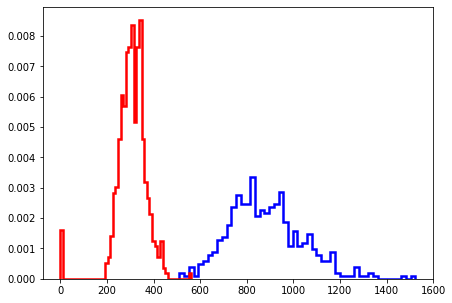

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
_, _, _ = ax.hist(q_gamma_bck, bins=50, histtype="step", lw=2.5, color="b", density=True)
_, _, _ = ax.hist(q_gamma_s, bins=50, histtype="step", lw=2.5, color="r", density=True)

In [93]:
#This is my observation - only background
nBDs=100; relT_R=0.10; relM_R=0.10; relR_R=0.10; relA_R=0.10
robs_R, Tobs_R, mass_R, ages_R = mock_population_all(nBDs, relT_R, relM_R, relR_R, relA_R,
                                         0, 1., 1., 
                                         rho0_true=rho0, 
                                         v=None)

xi         = np.transpose(np.asarray([ages_R, mass_R]))                            
Teff       = griddata(points, values, xi)                                        
heat_int_R = heat(Teff, np.ones(len(Teff))*R_jup.value)

In [168]:
# Asumme a given gamma
gamma       = 1.

def UL(gamma, Tobs_R, robs_R, mass_R, heat_int_R, relT_R):
    # Calculate TS_obs
    q_gamma_obs = TS(gamma, 1., 5., Tobs_R, robs_R, mass_R, heat_int_R, relT_R)
    
    # Construct pdf of TS for signal + background
    steps       = 200
    q_gamma_s   = np.ones(steps)
    path   = "/home/mariacst/exoplanets/exoplanets/data/"
    data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
    points = np.transpose(data[0:2, :])
    values = data[2]
    # Should I add noise in the generation of toy Monte Carlo experiments???
    nBDs=100; relT=0.1; relM=0.1; relR=0.1; relA=0.1
    for i in range(steps):
        robs, Tobs, mass, ages = mock_population_all(nBDs, relT, relM, relR, relA,
                                                 1., gamma, 5., 
                                                 rho0_true=rho0, 
                                                 v=None)    
        xi       = np.transpose(np.asarray([ages, mass]))                            
        Teff     = griddata(points, values, xi)                                        
        heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
        
        q_gamma_s[i] = TS(gamma, 1., 5., Tobs, robs, mass, heat_int, relT, rho0=0.42, v=None)
        
    counts, bins_ed, _ = ax.hist(q_gamma_s, bins=50, histtype="step", lw=2.5, color="r", density=True)
    
    pos = np.where(bins_ed > q_gamma_obs)
    _p = 0
    for i in range(len(pos[0])):
        _p += counts[-1-i]*(bins[1] + bins[0])
    #if np.abs(_p-0.05) < 0.01:
    #    break
    return _p, counts, bins_ed

In [171]:
gamma   = np.linspace(0.5, 1., 15)
p       = []
counts  = [] 
bins_ed = []

for g in gamma:
    _p, _c, _b = UL(g, Tobs_R, robs_R, mass_R, heat_int_R, relT_R)
    p.append(_p)
    counts.append(_c)
    bins_ed.append(_b)
    print(g, _p)
    if _p < 0.05:
        break

0.5 1.2339245278179403
0.5357142857142857 0.9124201573208439
0.5714285714285714 0.631829981691125
0.6071428571428571 0.2861507592688307
0.6428571428571428 0.4449823350783776
0.6785714285714286 0.46772999830686246
0.7142857142857143 0.18320843381240806
0.75 0.08857881112053015
0.7857142857142857 0.1350283164837967
0.8214285714285714 0.1092093937267057
0.8571428571428571 0.03624429209945426
0.8928571428571428 0
0.9285714285714286 0


KeyboardInterrupt: 

In [122]:
from scipy.stats import chi2
def half_chi2(q):
    if q==0:
        return (0.5 + chi2.pdf(q, 1))
    else:
        return (chi2.pdf(q, 1))
    
#def half_chi2(q):
#    return (np.heaviside(-q, 0.5) + chi2(q, 1))

q    = np.linspace(0, 8, 100)
f_th = [half_chi2(_q) for _q in q]

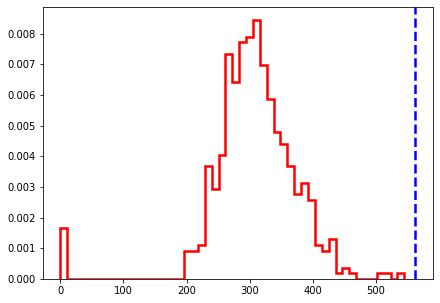

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

#ax.plot(q, f_th, color="k", ls=":", lw=2.5)

ax.axvline(q_gamma_obs, ls="--", color="blue", lw=2.5)
counts, bins_ed, _ = ax.hist(q_gamma_s, bins=50, histtype="step", lw=2.5, color="r", density=True)

**Final tentative**

For this part:

\begin{equation}
\ln\mathcal{L}_{s+b}(\gamma, r_s, f) \propto -\frac{1}{2\sigma_T^2}\sum_{i=1}^{N}\frac{\left(T_{DM, i}(\gamma, r_s, f)+T_{int, i}-T_{obs, i}\right)^2}{T_{obs, i}^2}
\end{equation}

and 

\begin{equation}
\ln\mathcal{L}_{b} \propto -\frac{1}{2\sigma_T^2}\sum_{i=1}^{N}\frac{\left(T_{int, i}-T_{obs, i}\right)^2}{T_{obs, i}^2}
\end{equation}


But the test statistics is given by:

\begin{equation}
TS = q_\gamma = 
-2\ln\left(\frac{\mathcal{L}_{s+b}(\gamma, \hat{\hat{f}})}{\mathcal{L}_b}\right)
\end{equation}

In [2]:
def lnL_sb(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Return ln(L) assuming predicted temperature = DM + intrinsic
    """  
    # Calculate predicted temperature (DM + intrinsic)
    T = temperature_withDM(robs, heat_int, f=f, M=Mobs*M_sun.value, parameters=[gamma, rs, rho0], v=v)
    # return
    return -0.5*np.sum(((T-Tobs)/(relT*Tobs))**2.) 

def lnL_b(Tobs, heat_int, relT):
    """
    Return ln(L) assuming predicted temperature = intrinsic
    """  
    # Calculate predicted intrinsic temperature
    T = temperature(heat_int, R_jup.value).value
    # return
    return -0.5*np.sum(((T-Tobs)/(relT*Tobs))**2.) 


def _lnL_sb_minimizer(p, gamma, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Return -2ln(L) (assumes Temperature = DM + intrinsic)
    """
    # free parameters of the fitting  
    f = p["f"]
    # Calculate predicted Temperature (DM + intrinsic)
    T = temperature_withDM(robs, heat_int, f=f, M=Mobs*M_sun.value, parameters=[gamma, rs, rho0], v=v)
    # return
    return ((T-Tobs)/(relT*Tobs))**2.

In [3]:
def TS(gamma, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Test statistics
    """
    params = Parameters()
    params.add("f", value=0.5, min=0., max=1.)
    out = minimize(_lnL_sb_minimizer, params, args=(gamma, rs, Tobs, robs, Mobs, heat_int, relT))
    assert out.success == True, "MLE gamma could not be found!"
    f_ML = out.params["f"].value
    #print("f_ML = ", f_ML)
    # return
    return (-2.*lnL_sb(gamma, f_ML, rs, Tobs, robs, Mobs, heat_int, relT)-2*lnL_b(Tobs, heat_int, relT))

Compute pdf for TS

In [13]:
def p_value(gamma_k, f, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R, steps=200):
    """
    Return p-value and TS pdf for gamma_k @ (f, rs)
    """
    # Find the MLE of f in observation
    params = Parameters()
    params.add("f", value=0.5, min=0., max=1.)
    out = minimize(_lnL_sb_minimizer, params, args=(gamma_k, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R))
    assert out.success == True, "MLE gamma could not be found!"
    f_ML_obs = out.params["f"].value
    print("f_ML_obs = ", f_ML_obs)
    # Compute TS pdf
    TS_k  = np.zeros(steps)
    # Load ATMO2020 model
    path   = "/home/mariacst/exoplanets/exoplanets/data/"
    data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
    points = np.transpose(data[0:2, :])
    values = data[2]
    for i in range(steps):
        # Generate mock data sample under the assumption of gamma_k and f_ML_obs
        robs, Tobs, Mobs, ages = mock_population_all(nBDs, relT_R, relM_R, relR_R, relA_R,
                                                     f_ML_obs, gamma_k, rs)
        # Predicted intrinsic temperatures
        xi       = np.transpose(np.asarray([ages, Mobs]))                            
        Teff     = griddata(points, values, xi)                                        
        heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)   
        # TS
        TS_k[i] = TS(gamma_k, f, rs, Tobs, robs, Mobs, heat_int, relT_R)
    # TS pdf @ gamma_k
    counts, bins_ed, _ = plt.hist(TS_k, bins=50, density=True)
    # observed TS
    q_gamma_k_obs = TS(gamma_k, f, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R)
    # Compute p-value
    pos = np.where(bins_ed > q_gamma_k_obs)
    _p = 0
    for i in range(len(pos[0])):
        _p += counts[-1-i]*(bins_ed[1] + bins_ed[0])
    # return
    return _p, counts, bins_ed

*Real* observation - only background

In [14]:
nBDs=100; relT_R=0.10; relM_R=0.10; relR_R=0.10; relA_R=0.10
rho0=0.42
# Load ATMO2020 model
path   = "/home/mariacst/exoplanets/exoplanets/data/"
data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]
    
robs_R, Tobs_R, mass_R, ages_R = mock_population_all(nBDs, relT_R, relM_R, relR_R, relA_R,
                                         0, 1., 1., 
                                         rho0_true=rho0, 
                                         v=None)

xi         = np.transpose(np.asarray([ages_R, mass_R]))                            
Teff       = griddata(points, values, xi)                                        
heat_int_R = heat(Teff, np.ones(len(Teff))*R_jup.value)

f_ML_obs =  0.4141606863393824
0.0 53.38317331646079
f_ML_obs =  0.28984537187692533
0.10714285714285714 62.792146196792295
f_ML_obs =  0.2017796143561405
0.21428571428571427 55.526051995860584
f_ML_obs =  0.1409915906912168
0.3214285714285714 58.48550321308226
f_ML_obs =  0.0988542276623326


KeyboardInterrupt: 

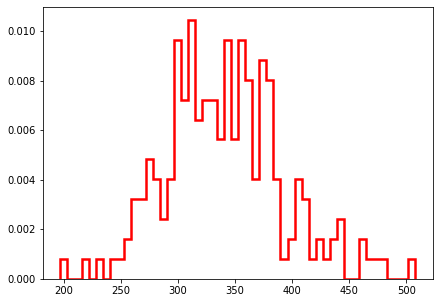

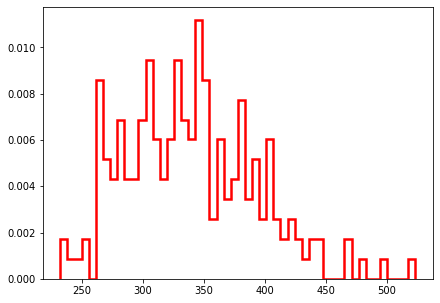

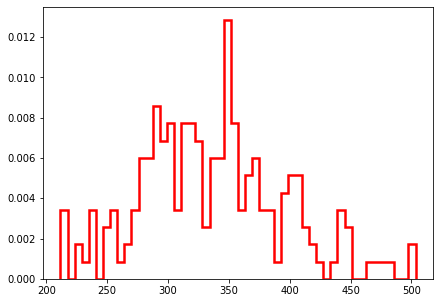

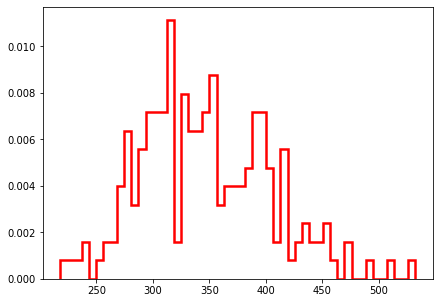

In [15]:
gamma_k = np.linspace(0., 1.5, 15)
rs      = 5.
p       = []
counts  = [] 
bins_ed = []

for g in gamma_k:
    _p, _c, _b = p_value(g, rs, Tobs_R, robs_R, mass_R, heat_int_R, relT_R)
    p.append(_p)
    counts.append(_c)
    bins_ed.append(_b)
    print(g, _p)
    if _p < 0.05:
        break

The problem is that $\hat{\hat{f}}(\gamma)\sim 0$, therefore $\mathcal{L_{s+b}} --> \mathcal{L_{b}}$ and $\gamma$ is not really influencing the results. We are not able to set an UL! 

Solution: calculate UL for given value of $f$

In [33]:
def lnL_sb(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Return ln(L) assuming predicted temperature = DM + intrinsic
    """  
    # Calculate predicted temperature (DM + intrinsic)
    T = temperature_withDM(robs, heat_int, f=f, M=Mobs*M_sun.value, 
                           parameters=[gamma, rs, rho0], v=v)
    # return
    return -0.5*np.sum(((T-Tobs)/(relT*Tobs))**2.) 

def lnL_b(Tobs, heat_int, relT):
    """
    Return ln(L) assuming predicted temperature = intrinsic
    """  
    # Calculate predicted intrinsic temperature
    T = temperature(heat_int, R_jup.value).value
    # return
    return -0.5*np.sum(((T-Tobs)/(relT*Tobs))**2.) 

def _lnL_sb_minimizer(p, gamma, rs, Tobs, robs, Mobs, heat_int, relT, 
                      rho0=0.42, v=None):
    """
    Return -2ln(L) (assumes Temperature = DM + intrinsic)
    """
    # free parameters of the fitting  
    f = p["f"]
    # Calculate predicted Temperature (DM + intrinsic)
    T = temperature_withDM(robs, heat_int, f=f, M=Mobs*M_sun.value, 
                           parameters=[gamma, rs, rho0], v=v)
    # return
    return ((T-Tobs)/(relT*Tobs))**2.

def TS(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Test statistics
    """
    # return
    return (-2.*lnL_sb(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0, v)
            -2*lnL_b(Tobs, heat_int, relT))


def p_value(gamma_k, f, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R, 
            steps=300):
    """
    Return p-value and TS pdf for gamma_k @ (f, rs)
    """
    # Find the MLE of f in observation
    params = Parameters()
    params.add("f", value=0.5, min=0., max=1.)
    out = minimize(_lnL_sb_minimizer, params, 
                   args=(gamma_k, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R))
    assert out.success == True, "MLE gamma could not be found!"
    f_ML_obs = out.params["f"].value
    #print("f_ML_obs = ", f_ML_obs)
    # Compute TS pdf
    TS_k  = np.zeros(steps)
    # Load ATMO2020 model
    path   = "/home/mariacst/exoplanets/exoplanets/data/"
    data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
    points = np.transpose(data[0:2, :])
    values = data[2]
    
    for i in range(steps):
        # Generate mock data sample under the assumption of gamma_k and f_ML_obs
        robs, Tobs, Mobs, ages = mock_population_all(nBDs, relT_R, relM_R, relR_R, 
                                         relA_R, f_ML_obs, gamma_k, rs)
        # Predicted intrinsic temperatures
        xi       = np.transpose(np.asarray([ages, Mobs]))
        Teff     = griddata(points, values, xi)
        heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
        # TS
        TS_k[i] = TS(gamma_k, f, rs, Tobs, robs, Mobs, heat_int, relT_R)
    # TS pdf @ gamma_k
    counts, bins_ed, _ = plt.hist(TS_k, bins=50, density=True)
    # observed TS
    q_gamma_k_obs = TS(gamma_k, f, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R)
    # Compute p-value
    pos = np.where(bins_ed > q_gamma_k_obs)
    _p = 0
    for i in range(len(pos[0])):
        _p += counts[-1-i]*(bins_ed[1] + bins_ed[0])
    # return
    return _p, counts, bins_ed, TS_k, q_gamma_k_obs

In [34]:
# Generate "real" observation assuming only background (no DM)
nBDs=100; relT_R=0.10; relM_R=0.10; relR_R=0.10; relA_R=0.10
rho0=0.42
# Load ATMO2020 model
path   = "/home/mariacst/exoplanets/exoplanets/data/"
data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]
np.random.seed(42) # ========= reproducable results!
robs_R, Tobs_R, mass_R, ages_R = mock_population_all(nBDs, relT_R, relM_R, 
                                     relR_R, relA_R,
                                     0, 1., 1., rho0_true=rho0, v=None)
xi         = np.transpose(np.asarray([ages_R, mass_R]))
Teff       = griddata(points, values, xi)
heat_int_R = heat(Teff, np.ones(len(Teff))*R_jup.value)

0.0 60.35502009061481


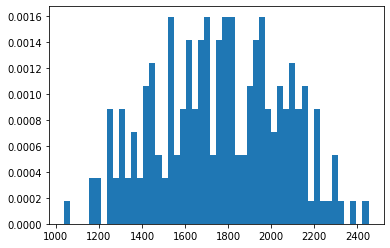

In [39]:
steps    = 200
f        = 1.
rs       = 5.
gamma_k  = np.linspace(0, 1.5, 10) 


for g in gamma_k:
    _p, _c, _b, TS_k, TS_obs = p_value(1.5, f, rs, Tobs_R, robs_R, mass_R, heat_int_R, relT_R, 
                        steps=steps)
    print(g, _p)
    break
    if _p < 0.05:
        gamma_up[i] = g
        p_up[i]     = _p
        print(rs[i], g, _p)
        break

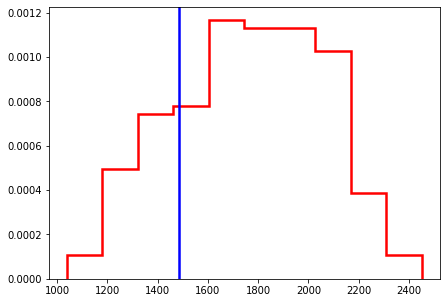

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
_, _, _ = ax.hist(TS_k, color="r", lw=2.5, histtype="step", density=True)
ax.axvline(TS_obs, color="blue", ls="-", lw=2.5)

## Modified frequentist approach CL$_S$

In [28]:
def lnL_sb(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Return ln(L) assuming predicted temperature = DM + intrinsic
    """  
    # Calculate predicted temperature (DM + intrinsic)
    T = temperature_withDM(robs, heat_int, f=f, M=Mobs*M_sun.value, 
                           parameters=[gamma, rs, rho0], v=v)
    # return
    return -0.5*np.sum(((T-Tobs)/(relT*Tobs))**2.) 

def lnL_b(Tobs, heat_int, relT):
    """
    Return ln(L) assuming predicted temperature = intrinsic
    """  
    # Calculate predicted intrinsic temperature
    T = temperature(heat_int, R_jup.value).value
    # return
    return -0.5*np.sum(((T-Tobs)/(relT*Tobs))**2.) 


def TS(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Test statistics
    """
    # return
    return (-2.*lnL_sb(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0, v)
            -2*lnL_b(Tobs, heat_int, relT))

In [5]:
def p_value_sb(gamma_k, f, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R, 
               ax, steps=300):
    """
    Return p-value and TS pdf for gamma_k @ (f, rs) under s+b hypothesis
    """
    # Compute TS pdf
    TS_k  = np.zeros(steps)
    # Load ATMO2020 model
    path   = "/home/mariacst/exoplanets/exoplanets/data/"
    data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
    points = np.transpose(data[0:2, :])
    values = data[2]    
    for i in range(steps):
        robs, Tobs, Mobs, ages = mock_population_all(nBDs, relT_R, relM_R, relR_R, 
                                         relA_R, f, gamma_k, rs)
        # Predicted intrinsic temperatures
        xi       = np.transpose(np.asarray([ages, Mobs]))
        Teff     = griddata(points, values, xi)
        heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
        # TS
        TS_k[i] = TS(gamma_k, f, rs, Tobs, robs, Mobs, heat_int, relT_R)
    # TS pdf @ gamma_k
    counts, bins_ed, _ = ax.hist(TS_k, bins=50, density=True, histtype="step", color="red", lw=2.5)
    # observed TS
    q_gamma_k_obs = TS(gamma_k, f, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R)
    # Compute p-value
    pos = np.where(bins_ed > q_gamma_k_obs)
    _p = 0
    for i in range(len(pos[0])):
        _p += counts[-1-i]*(bins_ed[1] + bins_ed[0])
    # return
    return _p#, counts, bins_ed

def p_value_b(gamma_k, f, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R, 
            ax, steps=300):
    """
    Return p-value and TS pdf for gamma_k @ (f, rs) under the b hypothesis
    """
    # Compute TS pdf
    TS_k  = np.zeros(steps)
    # Load ATMO2020 model
    path   = "/home/mariacst/exoplanets/exoplanets/data/"
    data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
    points = np.transpose(data[0:2, :])
    values = data[2]
    
    for i in range(steps):
        # Generate experiments under s+b hypothesis
        robs, Tobs, Mobs, ages = mock_population_all(nBDs, relT_R, relM_R, relR_R, 
                                         relA_R, 0., gamma_k, rs)
        # Predicted intrinsic temperatures
        xi       = np.transpose(np.asarray([ages, Mobs]))
        Teff     = griddata(points, values, xi)
        heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
        # TS
        TS_k[i] = TS(gamma_k, f, rs, Tobs, robs, Mobs, heat_int, relT_R)
    # TS pdf @ gamma_k
    counts, bins_ed, _ = ax.hist(TS_k, bins=50, density=True, histtype="step", color="blue", lw=2.5)
    # observed TS
    q_gamma_k_obs = TS(gamma_k, f, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R)
    ax.axvline(q_gamma_k_obs, ls="--", color="k", lw=2.5)
    # Compute p-value
    pos = np.where(bins_ed > q_gamma_k_obs)
    _p = 0
    for i in range(len(pos[0])):
        _p += counts[-1-i]*(bins_ed[1] + bins_ed[0])
    # return
    return _p#, counts, bins_ed

In [6]:
# Generate "real" observation assuming only background (no DM)
nBDs=100; relT_R=0.10; relM_R=0.10; relR_R=0.10; relA_R=0.10
rho0=0.42
# Load ATMO2020 model
path   = "/home/mariacst/exoplanets/exoplanets/data/"
data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]
np.random.seed(42) # ========= reproducable results!
robs_R, Tobs_R, mass_R, ages_R = mock_population_all(nBDs, relT_R, relM_R, 
                                     relR_R, relA_R,
                                     0, 1., 1., rho0_true=rho0, v=None)
xi         = np.transpose(np.asarray([ages_R, mass_R]))
Teff       = griddata(points, values, xi)
heat_int_R = heat(Teff, np.ones(len(Teff))*R_jup.value)

steps    = 200
f        = 1.
rs       = 20.
gamma_k  = 1.8

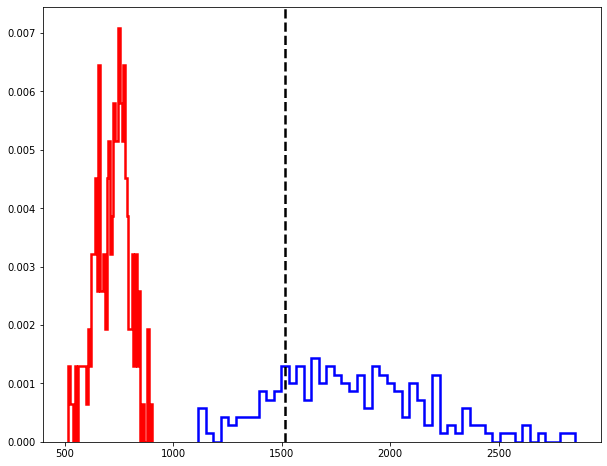

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

_p_sb = p_value_sb(gamma_k, f, rs, Tobs_R, robs_R, mass_R, heat_int_R, relT_R, ax, steps=steps)
_p_b  = p_value_b(gamma_k, f, rs, Tobs_R, robs_R, mass_R, heat_int_R, relT_R, ax, steps=steps)

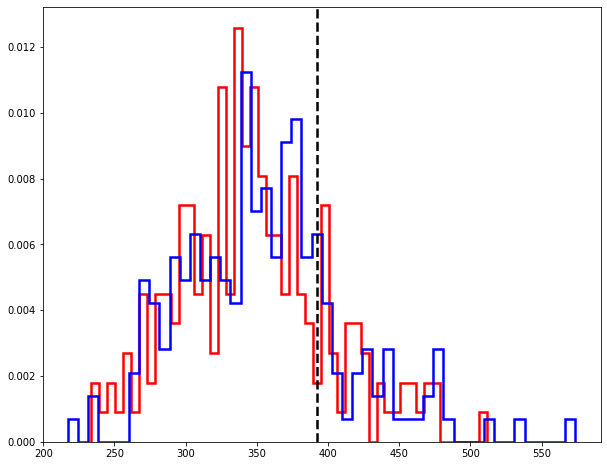

In [8]:
steps    = 200
f        = 1.
rs       = 20.
gamma_k  = 0.2

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

_p_sb = p_value_sb(gamma_k, f, rs, Tobs_R, robs_R, mass_R, heat_int_R, relT_R, ax, steps=steps)
_p_b  = p_value_b(gamma_k, f, rs, Tobs_R, robs_R, mass_R, heat_int_R, relT_R, ax, steps=steps)

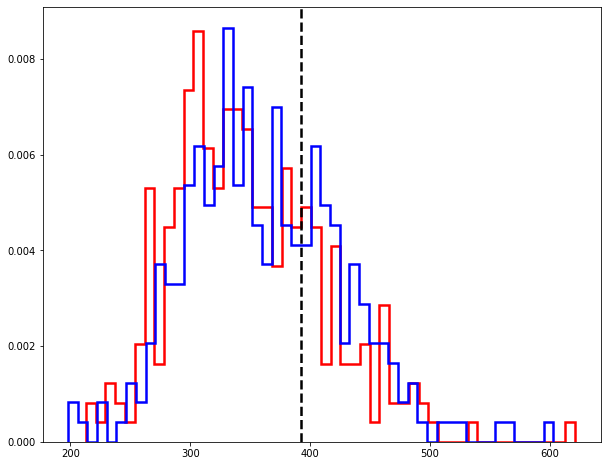

In [9]:
steps    = 300
f        = 1.
rs       = 20.
gamma_k  = 0.2

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

_p_sb = p_value_sb(gamma_k, f, rs, Tobs_R, robs_R, mass_R, heat_int_R, relT_R, ax, steps=steps)
_p_b  = p_value_b(gamma_k, f, rs, Tobs_R, robs_R, mass_R, heat_int_R, relT_R, ax, steps=steps)

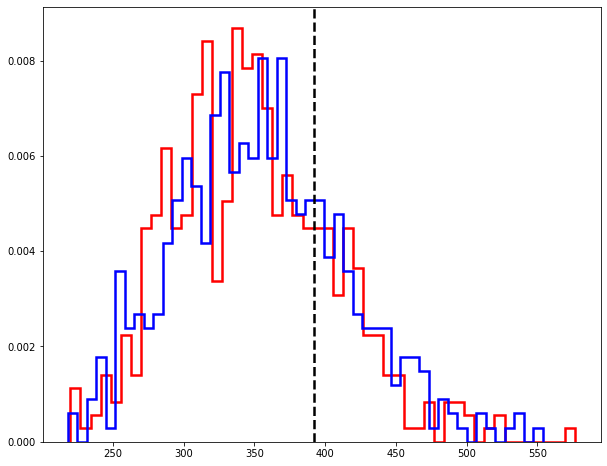

In [16]:
steps    = 500
f        = 1.
rs       = 20.
gamma_k  = 0.2

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

_p_sb = p_value_sb(gamma_k, f, rs, Tobs_R, robs_R, mass_R, heat_int_R, relT_R, ax, steps=steps)
_p_b  = p_value_b(gamma_k, f, rs, Tobs_R, robs_R, mass_R, heat_int_R, relT_R, ax, steps=steps)

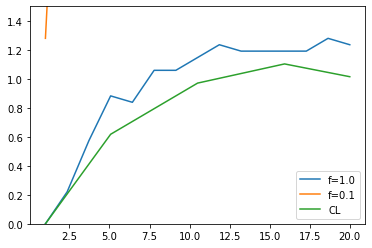

In [15]:
rs1 = np.linspace(1., 20., 15) 
rs2 = np.asarray([1.0, 5.071428571428571, 10.5, 15.928571428571429, 20.0])
UL1 = np.genfromtxt("/home/mariacst/exoplanets/exoplanets/python/UL_f1.0_1.dat", unpack=True)[0]
UL2 = np.genfromtxt("/home/mariacst/exoplanets/exoplanets/python/UL_f0.1_4.dat", unpack=True)[0]
UL3 = np.genfromtxt("/home/mariacst/exoplanets/exoplanets/python/UL_f1.0_6.dat", unpack=True)[0]

fig, ax = plt.subplots()
ax.plot(rs1, UL1 , label="f=1.0")
ax.plot(rs2, UL2 , label="f=0.1")
ax.plot(rs2, UL3 , label="CL")
ax.set_ylim(0., 1.5)

ax.legend()

missing 86
missing 98


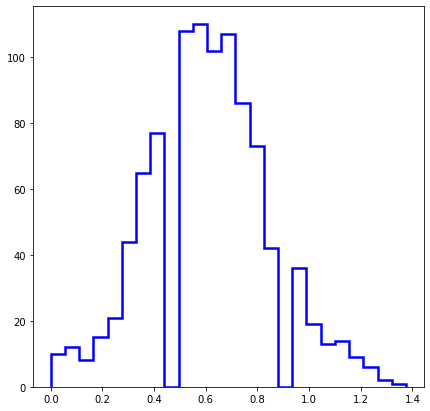

In [23]:
_path    = "/home/mariacst/exoplanets/exoplanets/python/UL/"
steps    = 300
    
gamma_up = np.array([])  
for i in range(100):
    try:
        _a       = np.genfromtxt(_path + "UL_f1.0_rs5.0_{}_steps{}.dat".format(i+1, steps))
        gamma_up = np.concatenate((gamma_up, _a), axis=None)
    except:
        print("missing", i+1)
    
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
_, bins, _ = ax.hist(gamma_up, bins=25, histtype="step", lw=2.5, color="blue")

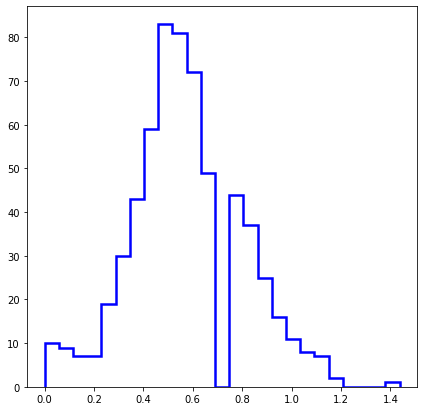

In [25]:
_path    = "/home/mariacst/exoplanets/exoplanets/python/UL/"
steps    = 500
    
gamma_up = np.array([])  
for i in range(100):
    try:
        _a       = np.genfromtxt(_path + "UL_f1.0_rs5.0_{}_steps{}.dat".format(i+1, steps))
        gamma_up = np.concatenate((gamma_up, _a), axis=None)
    except:
        continue
        #print("missing", i+1)
    
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
_, bins, _ = ax.hist(gamma_up, bins=25, histtype="step", lw=2.5, color="blue")

In [32]:
# Generate "real" observation assuming only background (no DM)
nBDs=100; relT_R=0.10; relM_R=0.10; relR_R=0.10; relA_R=0.10
rho0=0.42
# Load ATMO2020 model
path   = "/home/mariacst/exoplanets/exoplanets/data/"
data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]
np.random.seed(42) # ========= reproducable results!
robs_R, Tobs_R, Mobs_R, ages_R = mock_population_all(nBDs, relT_R, relM_R, 
                                     relR_R, relA_R,
                                     0, 1., 1., rho0_true=rho0, v=None)

xi         = np.transpose(np.asarray([ages_R, Mobs_R]))
Teff       = griddata(points, values, xi)
heat_int_R = heat(Teff, np.ones(len(Teff))*R_jup.value)

In [40]:
# observed
f = 1.; rs = 5.
gamma = np.linspace(0., 2., 30)
q_obs = []
for g in gamma:
    q_obs.append(TS(g, f, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R))
    
    
# expected bckg
np.random.seed(2)
robs, Tobs, Mobs, ages = mock_population_all(nBDs, relT_R, relM_R, relR_R, relA_R, 0, 1., 1., 
                                             rho0_true=rho0, v=None)

xi       = np.transpose(np.asarray([ages, Mobs]))
Teff     = griddata(points, values, xi)
heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)

q_bck = []
for g in gamma:
    q_bck.append(TS(g, f, rs, Tobs, robs, Mobs, heat_int, relT_R))

    
    
# expected bckg
np.random.seed(7)
robs, Tobs, Mobs, ages = mock_population_all(nBDs, relT_R, relM_R, relR_R, relA_R, f, 1., 5., 
                                             rho0_true=rho0, v=None)

xi       = np.transpose(np.asarray([ages, Mobs]))
Teff     = griddata(points, values, xi)
heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)

q_sb = []
for g in gamma:
    q_sb.append(TS(g, f, rs, Tobs, robs, Mobs, heat_int, relT_R))

Text(0, 0.5, 'TS')

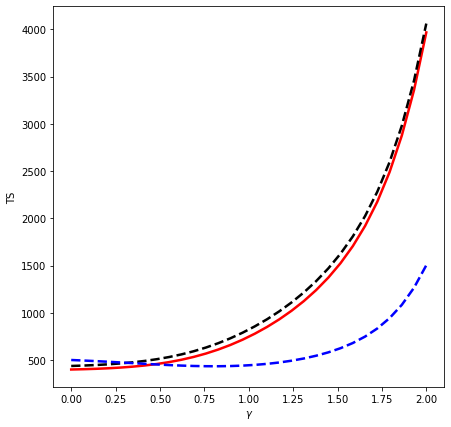

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.plot(gamma, q_obs, color="r", lw=2.5, label="observed")
ax.plot(gamma, q_bck, color="k", lw=2.5, ls="--", label="Expected background")
ax.plot(gamma, q_sb, color="blue", lw=2.5, ls="--", label=r"Expected s($\gamma=1$) + b") # creo que esta mal!
ax.set_xlabel(r"$\gamma$")
ax.set_ylabel("TS")